# GenAI-Camp: Day 01
## Lesson: Modeling

This lesson is intended to show you the basics of modeling using python.

During this lesson you will learn how to ...

- prepare data for model training
- train a simple neural network using pytorch
- visualize model performance metrics


### Set up the environment
Import the necessary libraries, set constants, and define helper functions.

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import tokenizers
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords
import string
from nltk.stem import SnowballStemmer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import os

In [7]:
# Check runtime environment to make sure we are running in a colab environment. 
if os.getenv("COLAB_RELEASE_TAG"):
   COLAB = True
   print("Running on COLAB environment.") 
else:
   COLAB = False
   print("WARNING: Running on LOCAL environment.")

In [8]:
# Define path of ressources
if COLAB:
    # Clone the data repository into colab
    !git clone https://github.com/openknowledge/workshop-genai-camp-data.git
    ROOT_PATH = "/content/workshop-genai-camp-data/day-01/"
else:
    ROOT_PATH = "../"
DATA_PATH = ROOT_PATH + "/data"
MODEL_PATH = ROOT_PATH + "/models"

IMDB_FILE = DATA_PATH + "/imdb_dataset.csv"
TOKENIZER_FILE = MODEL_PATH + "/tokenizer.json"

In [9]:
# Data preparation functions

def rename_columns(df: pd.DataFrame) -> pd.DataFrame:
    """
    Rename columns of the dataframe to make them more readable.
    """

    df_renamed = df.copy()
    df_renamed.rename(columns={"text": "review", "label": "sentiment"}, inplace=True)

    return df_renamed


def remove_punctuation(text: str) -> str:
    """
    Remove punctuation from the text.
    """

    translation_table = {ord(i): None for i in string.punctuation}
    
    return text.translate(translation_table)


def remove_html_tags(text: str) -> str:
    """
    Remove HTML tags from a string.
    """
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()


def transform_to_lowercase(text: str) -> str:
    """
    Transform a string to lowercase.
    """
    return text.lower()


nltk.download('stopwords')

def remove_stopwords(text: str) -> str:
    """
    Remove stopwords from a string.
    """

    # Load the english stopwords
    stop_words = set(stopwords.words('english'))

    words = text.split()

    filtered_text = [word for word in words if word not in stop_words]
    return ' '.join(filtered_text)


def stem_text(text: str) -> str:
    """
    Stem the text using a nltk stemmer.
    """

    # Initialize the stemmer
    stemmer = SnowballStemmer("english")

    # Split the text into words
    words = text.split()

    # Stem each word
    stemmed_words = [stemmer.stem(word) for word in words]

    return ' '.join(stemmed_words)


def preparation_pipeline(df: pd.DataFrame) -> pd.DataFrame:
    """
    Prepares the DataFrame for modeling using the available preprocessing functions.
    """

    # Copy dataframe
    df_processed = df.copy()

    # Remove HTML tags
    df_processed['review'] = df_processed['review'].apply(remove_html_tags)

    # Remove punctuations
    df_processed['review'] = df_processed['review'].apply(remove_punctuation)
    
    # Transform to lowercase
    df_processed['review'] = df_processed['review'].apply(transform_to_lowercase)
    
    # Remove stopwords
    df_processed['review'] = df_processed['review'].apply(remove_stopwords)

    # Stem the text
    df_processed['review'] = df_processed['review'].apply(stem_text)
    
    return df_processed

[nltk_data] Downloading package stopwords to /home/tim/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Preparing data for model training
Even after completing the preprocessing pipeline, further data preparation steps are essential to optimize the performance of neural networks.

In [10]:
# Load the IMDB dataset
df = pd.read_csv(IMDB_FILE)

# Run the preprocessing pipeline
df = rename_columns(df)
df_processed = preparation_pipeline(df)
df_processed.head()

,review,sentiment,year
0,grew b 1965 watch love thunderbird mate school...,0,2015
1,put movi dvd player sat coke chip expect hope ...,0,2022
2,peopl know particular time past like feel need...,0,2015
3,even though great interest biblic movi bore de...,0,2021
4,im die hard dad armi fan noth ever chang got t...,1,2021


### Tokenization
In order for neural networks to process text, it must be converted into numerical format. Tokenization is the process of splitting text into individual words or subwords and mapping them to unique integers or embeddings. This structured format enables neural networks to understand and learn from the input data.

In [11]:
# Our corpus is defined by the available data
corpus = df_processed['review'].to_list()

# Define some constants
UNKNOWN_TOKEN = '[UNK]'
CONTINUING_SUBWORD_PREFIX = '##'
VOCABULARY_SIZE = 2000

# Change this if you want to train the tokenizer yourself.
# Since this might take a while, we will use a pretrained tokenizer
# to save time.
TRAIN_TOKENIZER = False

if TRAIN_TOKENIZER:
    # Load a Byte-Pair Encoder for tokenization
    tokenizer = tokenizers.Tokenizer(tokenizers.models.BPE(
        unk_token=UNKNOWN_TOKEN,
        continuing_subword_prefix=CONTINUING_SUBWORD_PREFIX,
    ))

    # Set up a trainer for the tokenizer
    trainer = tokenizers.trainers.BpeTrainer(
        vocab_size = VOCABULARY_SIZE,
        special_tokens=[UNKNOWN_TOKEN],
    )

    # Train the tokenizer on the corpus
    tokenizer.train_from_iterator(corpus, trainer)
else:
    # Load a pretrained tokenizer
    tokenizer = tokenizers.Tokenizer.from_file(TOKENIZER_FILE)

In [12]:
# Visualize the tokenization
text = "this is a test sentence!"
encoding = tokenizer.encode(text)
print(f"Tokens: \t{encoding.tokens}")
print(f"Tokens-Ids:\t{encoding.ids}")

Tokens: 	['th', 'is ', 'is ', 'a ', 'test ', 's', 'ent', 'en', 'ce', '[UNK]']
Tokens-Ids:	[138, 648, 648, 234, 1274, 32, 763, 140, 1596, 0]


### Vectorization
Tokenized text needs to be converted into numerical vectors for the model to process. In addition, the neural network we will use later, needs a fixed input dimension. This can be done using a technique called "Bag of Words" (BoW), which represents text by the frequency of words, or here tokens.

In [13]:
def vectorize_text(text: str, tokenizer: tokenizers.Tokenizer):
  """
  Vectorizes the input text using a tokenizer.
  Args:
      text (str): The input text to be vectorized.
      tokenizer (tokenizers.Tokenizer): The tokenizer to use for vectorization.
  Returns:
      np.ndarray: A vector representation of the input text.
  """
  # Tokenize the text
  encoding = tokenizer.encode(text)

  # Create a vector of zeros with the size of the vocabulary
  vector = np.zeros(VOCABULARY_SIZE)

  # Bag Of Words: Count the number of times each token appears in the text
  for token_id in encoding.ids:
      vector[token_id] +=1

  # Normalize the vector
  vector = vector / vector.sum()
  return vector

In [14]:
# Visualize the vectorization
text = "this is a test sentence!"
vector = vectorize_text(text, tokenizer)
print(f"Length of the vector: {len(vector)}")
print(f"Vector: {vector}")

Length of the vector: 2000
Vector: [0.1 0.  0.  ... 0.  0.  0. ]


### Data Split
To evaluate the performance of the model, the data must be split into training and test sets. This allows the model to learn patterns on the training set and be validated on unseen data from the test set, ensuring that it generalizes well and is not overfitting. A typical split is 80% for training and 20% for testing.

In [15]:
# Split the data into training and test sets
df_train, df_test = train_test_split(df_processed, test_size=0.2, random_state=42)

# Show some information about the split
print(f"Number of training samples: {len(df_train)}")
print(f"Number of test samples: {len(df_test)}")

Number of training samples: 32000
Number of test samples: 8000


In [16]:
# Vectorize the splitted data
train_vectors = []
for text in df_train['review']:
  train_vectors.append(vectorize_text(text, tokenizer))


test_vectors = []
for text in df_test['review']:
  test_vectors.append(vectorize_text(text, tokenizer))


In [17]:
# Show an example of the vectorization
print(f"Vectorized training sample: {train_vectors[0]}")

Vectorized training sample: [0. 0. 0. ... 0. 0. 0.]


### Model Training
Once the data is fully preprocessed and prepared, the next step is model training. In this phase, a machine learning model, such as a neural network, learns patterns and relationships from the training data to make predictions.  
*Neural networks* are powerful models inspired by the human brain, consisting of layers of interconnected neurons. Each neuron receives input, processes it, and passes the result to the next layer. The network adjusts its internal parameters during training to minimize the error between its predictions and the actual results.  
During the training process, several key settings, known as *hyperparameters*, need to be configured:
* *Learning Rate*: Controls how much the model adjusts in response to errors.
* *Batch Size*: Defines the number of samples processed before updating the model.
* *Number of Epochs*: Determines how many times the entire training dataset is passed through the network.
* *Number of Layers and Neurons*: Specifies the structure of the network, affecting its capacity to learn complex patterns.

Unlike model parameters, which are learned during training, hyperparameters must be set before the learning process begins. Finding the optimal configuration often requires experimentation and techniques like Grid Search or Random Search.

In [ ]:
# Define hyperparameters
BATCH_SIZE = 64
INPUT_DIM = VOCABULARY_SIZE
OUTOUT_DIM = 2
HIDDEN_DIM = 64
LEARNING_RATE = 0.0003
DROPOUT_RATE = 0.7
NUM_EPOCHS = 30

In [19]:
# We will use the torch library to create our model. Therefore, we need to convert our data into torch tensors.
# Convert vectors
train_vectors = torch.tensor(train_vectors, dtype=torch.float32)
test_vectors = torch.tensor(test_vectors, dtype=torch.float32)

# Convert labels
train_labels = torch.tensor(df_train['sentiment'].values, dtype=torch.long)
test_labels = torch.tensor(df_test['sentiment'].values, dtype=torch.long)

/tmp/ipykernel_46759/3770144509.py:3: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  train_vectors = torch.tensor(train_vectors, dtype=torch.float32)


In [20]:
# Create a dataset for the training and test data
train_dataset = TensorDataset(train_vectors, train_labels)
test_dataset = TensorDataset(test_vectors, test_labels)

# Create a DataLoader for the training and test data
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False,)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [21]:
# Define the model
class SentimentClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(SentimentClassifier, self).__init__()
        self.linear_1 = nn.Linear(input_dim, hidden_dim)
        self.drop_out_1 = nn.Dropout(p=dropout_rate)
        self.relu = nn.ReLU()
        self.linear_2 = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.linear_1(x)
        x = self.relu(x)
        x = self.drop_out_1(x)
        x = self.linear_2(x)
        x = self.softmax(x)
        return x

In [22]:
# Create a wrapper class for the training and evaluation process

class Trainer:
    """
    Trainer class for training and evaluating a PyTorch model.
    """
    
    def __init__(self, model: nn.Module, train_loader: DataLoader, test_loader: DataLoader,
                 criterion: nn.Module, optimizer: optim.Optimizer, num_epochs: int):
        """ 
        Trainer class for training and evaluating a PyTorch model.
        Args:
            model (nn.Module): The model to be trained.
            train_loader (DataLoader): DataLoader for the training data.
            test_loader (DataLoader): DataLoader for the test data.
            criterion (nn.Module): Loss function.
            optimizer (optim.Optimizer): Optimizer for the model.
            num_epochs (int): Number of epochs to train the model.
        """
        self.model = model
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.train_accuracies = []
        self.test_accuracies = []

    def train_epoch(self):
        """
        Train the model for one epoch.
        """
        self.model.train()
        for inputs, labels in self.train_loader:
            self.optimizer.zero_grad()
            outputs = self.model(inputs)
            loss = self.criterion(outputs, labels)
            loss.backward()
            self.optimizer.step()

    def evaluate(self, loader) -> float:
        """
        Evaluate the model on the given DataLoader.
        Args:
            loader (DataLoader): DataLoader for the evaluation data.
        Returns:
            float: Accuracy of the model on the evaluation data.
        """
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for inputs, labels in loader:
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

    def train(self):
        """
        Train the model for a specified number of epochs.
        """
        for epoch in range(self.num_epochs):
            self.train_epoch()
            train_accuracy = self.evaluate(self.train_loader)
            test_accuracy = self.evaluate(self.test_loader)

            self.train_accuracies.append(train_accuracy)
            self.test_accuracies.append(test_accuracy)

            print(f'Epoch [{epoch + 1}/{self.num_epochs}] '
                  f'Train Accuracy: {train_accuracy:.2f}% '
                  f'Test Accuracy: {test_accuracy:.2f}%')

    def final_test_accuracy(self):
        final_accuracy = self.evaluate(self.test_loader)
        print(f'Final Accuracy on Test Data: {final_accuracy:.2f}%')
        return final_accuracy


In [23]:
# Run the training

# Create the model
model = SentimentClassifier(INPUT_DIM, HIDDEN_DIM, OUTOUT_DIM, DROPOUT_RATE)

# Create the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Instantiate the Trainer class
trainer = Trainer(model, train_loader, test_loader, criterion, optimizer, NUM_EPOCHS)

# Train the model
trainer.train()

# Evaluate the model on the test data
trainer.final_test_accuracy()

Epoch [1/40] Train Accuracy: 72.86% Test Accuracy: 72.25%
Epoch [2/40] Train Accuracy: 78.32% Test Accuracy: 77.60%
Epoch [3/40] Train Accuracy: 81.83% Test Accuracy: 80.80%
Epoch [4/40] Train Accuracy: 82.61% Test Accuracy: 81.55%
Epoch [5/40] Train Accuracy: 83.69% Test Accuracy: 82.45%
Epoch [6/40] Train Accuracy: 84.25% Test Accuracy: 82.81%
Epoch [7/40] Train Accuracy: 84.78% Test Accuracy: 83.30%
Epoch [8/40] Train Accuracy: 85.08% Test Accuracy: 83.46%
Epoch [9/40] Train Accuracy: 85.42% Test Accuracy: 83.84%
Epoch [10/40] Train Accuracy: 85.85% Test Accuracy: 83.79%
Epoch [11/40] Train Accuracy: 86.11% Test Accuracy: 84.10%
Epoch [12/40] Train Accuracy: 86.32% Test Accuracy: 84.45%
Epoch [13/40] Train Accuracy: 86.48% Test Accuracy: 84.41%
Epoch [14/40] Train Accuracy: 86.77% Test Accuracy: 84.64%
Epoch [15/40] Train Accuracy: 86.90% Test Accuracy: 84.75%
Epoch [16/40] Train Accuracy: 87.06% Test Accuracy: 84.83%
Epoch [17/40] Train Accuracy: 87.17% Test Accuracy: 85.11%
Epoch 

85.9375

### Exercise 01: Plotting Model Accuracy Over Epochs
Visualizing the training and testing accuracy of your model over time is crucial for understanding how well your model is learning. It can reveal if your model is:  
* *Underfitting*: Both train and test accuracies are low.
* *Overfitting*: Train accuracy is high, but test accuracy is low.
* *Well-fitted*: Both accuracies improve and stabilize over epochs  

Using Matplotlib, plot the training and testing accuracies stored in the Trainer class.

**Hints**:
* You can access i.e. the test accuracy by `trainer.test_accuracy`
* Use a lineplot from *matplotlib*

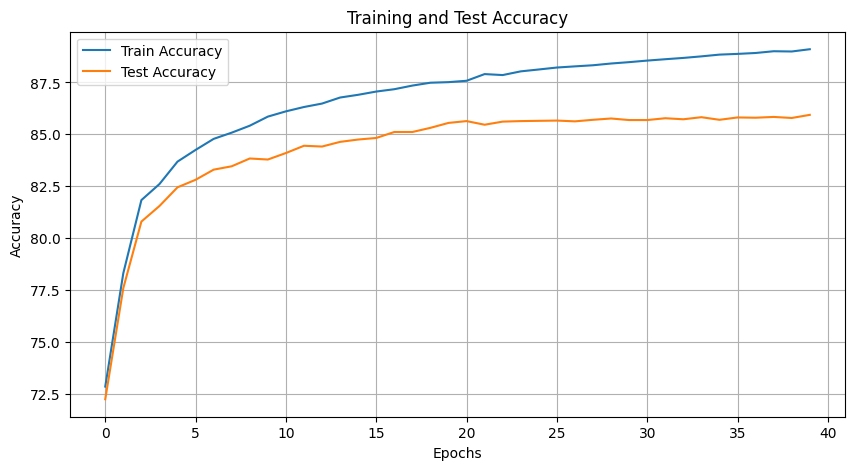

In [ ]:
# TODO: Visualize the training and test accuracies
# Plot the training and test accuracies
plt.figure(figsize=(10, 5))
plt.plot(trainer.train_accuracies, label='Train Accuracy')
plt.plot(trainer.test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Test Accuracy')
plt.legend()
plt.grid()
plt.show()

### Exercise 02: Model Inference
After training a model, it's important to test its inference capabilities on new, unseen data. This allows you to verify if your model generalizes well beyond the training and test sets.

In [26]:
# This function is used to predict the sentiment of a given text using the trained model.
def predict_sentiment(text: str, model: nn.Module, tokenizer: tokenizers.Tokenizer) -> tuple[int, float]: # tuple[label, probability]
    """
    Predict the sentiment of a given text using the trained model.
    Args:
        text (str): The text to be predicted.
        model (nn.Module): The trained model.
        tokenizer (tokenizers.Tokenizer): The tokenizer used for vectorization.
    Returns:
        int: The predicted sentiment (0 or 1).
    """

    # Preprocess the text
    processed_text = preparation_pipeline(pd.DataFrame({'review': [text]}))['review'][0]

    # Vectorize the text
    vector = vectorize_text(processed_text, tokenizer)
    vector = torch.tensor(vector, dtype=torch.float32).unsqueeze(0)

    # Predict the sentiment
    with torch.no_grad():
        output = model(vector)

    label = torch.argmax(output, dim=1).item()
    probability = output[0][label].item()

    return (label, probability)

def print_prediction(review: str, label: int, probability: float):
    """
    Print the prediction result.
    Args:
        review (str): The review text.
        label (int): The predicted sentiment (0 or 1).
        probability (float): The probability of the predicted sentiment.
    """
    sentiment = "positive" if label == 1 else "negative"
    print(f"Review: {review}\nPredicted Sentiment: {sentiment} ({probability:.2f})\n")


In [27]:
# TODO: Test the prediction function with some example reviews
review = "This movie was fantastic! I loved it."

# Predict the sentiment of the review
predicted_sentiment, predicted_probability = predict_sentiment(text=review, model=trainer.model, tokenizer=tokenizer)

# Print the predicted sentiments
print_prediction(review, predicted_sentiment, predicted_probability)


Review: This movie was fantastic! I loved it.
Predicted Sentiment: positive (1.00)



### (Bonus) Exercise 03: Saving and Restoring the Model from a Checkpoint
When training deep learning models, it's crucial to save your progress and be able to restore it later. This allows you to:
* *Resume Training*: Continue from where you left off.
* *Model Deployment*: Load the trained model for inference.
* *Experimentation*: Easily switch between different trained models.
Your task is to create two standalone functions for:
1. Saving the Model: Save the model's state to a checkpoint file.
2. Loading the Model: Restore the model from that checkpoint file.

**Hints**:
* see [pytorch documentation](https://docs.pytorch.org/tutorials/beginner/saving_loading_models.html) for examples of saving and loading models

In [28]:
# We only save the model state, not the optimizer state
# This is because we are not resuming training, but only using the model for inference
# If we want to resume training, we need to save the optimizer state as well.
def save_checkpoint(model: nn.Module, filename: str):
    """
    Save the model state to a file.
    Args:
        model (nn.Module): The model to be saved.
        filename (str): The name of the file to save the checkpoint to.
    """
    checkpoint = {
        'model_state_dict': model.state_dict(),
    }
    torch.save(checkpoint, filename)
    print(f"Model state has been saved to {filename}")


def load_checkpoint(model: nn.Module, filename: str):
    """
    Load the model state from a file.
    Args:
        model (nn.Module): The model to be loaded.
        filename (str): The name of the file to load the checkpoint from.
    """
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"Model state has been restored from {filename}")

In [29]:
# TODO: Save the model
checkpoint_file_name = 'sentiment_model.pth'
save_checkpoint(model=trainer.model, filename=checkpoint_file_name)

Model state has been saved to sentiment_model.pth


In [ ]:
# TODO: Initialize a new model
new_model = SentimentClassifier(INPUT_DIM, HIDDEN_DIM, OUTOUT_DIM, DROPOUT_RATE)

In [31]:
# Make a prediction with the new model. This is just to show that the model is not trained yet.
review = "This movie was terrible. I hated it."
new_model_prediction, new_model_probability = predict_sentiment(text=review, model=new_model, tokenizer=tokenizer)
print_prediction(review, new_model_prediction, new_model_probability)

Review: This movie was terrible. I hated it.
Predicted Sentiment: positive (0.53)



In [32]:
# TODO: Load the checkpoint
load_checkpoint(new_model, filename=checkpoint_file_name)

Model state has been restored from sentiment_model.pth


In [33]:
# Predict the sentiment of the review with the loaded model
new_model_prediction, new_model_probability = predict_sentiment(text=review, model=new_model, tokenizer=tokenizer)
print_prediction(review, new_model_prediction, new_model_probability)

Review: This movie was terrible. I hated it.
Predicted Sentiment: negative (1.00)



### Learnings
1. We differ between training and inference. 
2. We can use the trained model to make prediction
3. We need to preprocess the input to the model the same way as for the training
4. We can save the model state. This is just a binary file.